# Tests of Aria-1 (IONQ) QPU available through Amazon Braket

The goal is to perform additions in the Fourrier space to see where the QPU cease to perform reasonably well

In [35]:
import math
import random
import os
os.environ["AWS_ACCESS_KEY_ID"]=""
os.environ["AWS_SECRET_ACCESS_KEY"]=""
os.environ["AWS_SESSION_TOKEN"]=""
os.environ["AWS_REGION"]="us-east-1"

##################################################################
# Braket SDK v1.61.0
# Circuits !
from braket.circuits import Circuit, circuit
# Qubits !
from braket.circuits.qubit_set import QubitSetInput, QubitSet
from braket.circuits.qubit import Qubit
# Devices !
from braket.devices import Device, LocalSimulator   # Local simulator
from braket.aws import AwsDevice, AwsQuantumTask
# AWS simulators/QPU
local_simulator = LocalSimulator()
aria1 = AwsDevice("arn:aws:braket:us-east-1::device/qpu/ionq/Aria-1")
##################################################################

# Qiskt SDK v0.45.0
from qiskit.visualization import plot_histogram

# QFT and addition

We define fonctions to be able to create parameterized circuits for test purposes.

IONQ on Braket does not support phaseshift and cphaseshift gates, so we work around that by fallbacking on rz gates and hand crafted controlled-rz gates

In [36]:
@circuit.subroutine(register=True)
def crz(control_qubit, target_qubit, angle):
    crz = Circuit()
    crz.rz(target_qubit, angle/2)
    crz.cnot(control_qubit, target_qubit)
    crz.rz(target_qubit, -angle/2)
    crz.cnot(control_qubit, target_qubit)
    return crz

@circuit.subroutine(register=True)
def qft(qubits, reverse = False):
    qft = Circuit()
    num_qubits = len(qubits)
    for k in reversed(range(num_qubits)):
        qft.h(qubits[k])
        for j in reversed(range(k)):
            angle = 2*math.pi/(2**(1+k-j))
            if reverse:
                angle = -angle
            qft.crz(qubits[j], qubits[k], angle)
    if reverse:
        qft = Circuit(reversed(qft.instructions))
    return qft

@circuit.subroutine(register=True)
def add_classical_integer_in_fourrier(number_to_add: QubitSetInput, qubits: QubitSetInput):
    add_classical_integer_in_fourrier = Circuit()
    num_qubits = len(qubits)
    for qubit_num in range(num_qubits):
        angle = 0
        for a_i in range(qubit_num+1):
            if 2**a_i & number_to_add:
                k = 1 + qubit_num - a_i
                angle += 2*math.pi/(2**k)
        add_classical_integer_in_fourrier.rz(qubit_num, angle)
    return add_classical_integer_in_fourrier

def get_quantum_adder(qubits_count, initial_value, value_to_add):
    c = Circuit()
    qubits = [*range(qubits_count)]
    for i in range(qubits_count):
        if 2**i & initial_value:
            c.x(qubits[i])
    c.qft(qubits)
    c.add_classical_integer_in_fourrier(value_to_add, qubits)
    c.qft(qubits, reverse=True)
    return c

QUBITS = 16
INIT=sum([2**i for i in range(QUBITS-2, -1, -2)])
ADD=2**(QUBITS-1)-1

test = get_quantum_adder(QUBITS, INIT, ADD)
print(test)
measurement = local_simulator.run(test, shots=1000).result().measurement_counts
# There should only be one result because this circuit should be completly deterministic
assert len(measurement) == 1, f"Expected only one result, got {len(measurement)}: {measurement}"
for measure in measurement.keys():
    # Extract the bits for reg_b only from the resulting measurement, reverse them and convert them to the corresponding int
    result = int(''.join(reversed(measure)), 2)
    expected = (INIT + ADD) % 2**QUBITS
    # Verify that we obtain the correct result
    assert expected == result, f"Expect {expected} not {result}"

T   : |0|   1    |2|    3    |4|   5    |    6     |    7    |8|   9    |    10     |   11    |    12    |       13        |    14     |   15    |    16    |        17        |    18     |        19        |        20         |        21        |    22     |        23        |         24         |        25        |         26         |            27             |         28         |        29        |         30         |             31             |         32         |            33             |             34              |             35             |         36         |            37             |              38              |             39             |             40              |                 41                 |              42              |             43             |             44              |                 45                  |              46              |                 47                  |                  48                  |                 49     

# Challenge Aria-1 on a 5 qubits addition

In [26]:
QUBITS = 5
# Init will always be 01010101...01
init_val = sum([2**i for i in range(QUBITS-2, -1, -2)])
# We always add 1111111...111 (QUBITS-1 times)
value_to_add = 2**(QUBITS-1)-1
circuit5 = get_quantum_adder(QUBITS, init_val, value_to_add)

print(f"Circuit depth: {circuit5.depth}")

# As I am not Cresus, 200 shots per experiment will have to do...
aria1_circuit5_task_id = aria1.run(circuit5, shots=200).id

Circuit depth: 55


In [39]:
print('Status of task:', AwsQuantumTask(arn=aria1_circuit5_task_id).state())

Status of task: COMPLETED


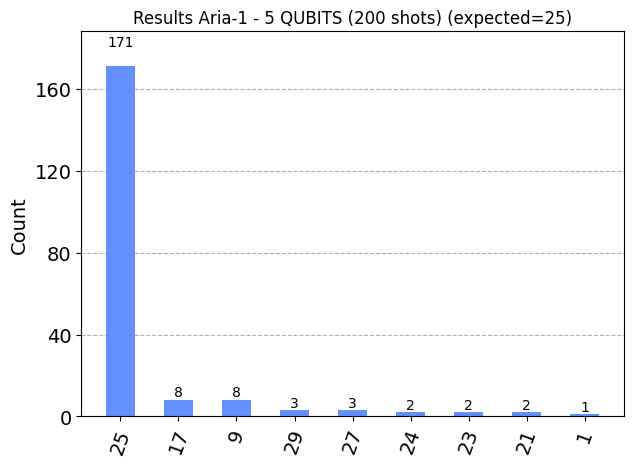

In [40]:
# Get the task results
measurement_counts = AwsQuantumTask(arn=aria1_circuit5_task_id).result().measurement_counts
# Transform labels into human-readable integers
# Keeps only the 20 higher counts
maxvals=20
measurement_counts_formated={}
for k, v in sorted(measurement_counts.items(), key=lambda o:o[1], reverse=True):
    maxvals-=1
    measurement_counts_formated.update({int(''.join(reversed(k)), 2):v})
    if maxvals<=0:
        break
# On vizualize les résultats avec Qiskit
QUBITS = 5
expected=sum([2**i for i in range(QUBITS-2, -1, -2)]) + 2**(QUBITS-1)-1
display(plot_histogram(measurement_counts_formated, title=f"Results Aria-1 - {QUBITS} QUBITS (200 shots) (expected={expected})", sort='value_desc'))

# Challenge Aria-1 on a 10 qubits addition

In [23]:
QUBITS = 10
# Init will always be 01010101...01
init_val = sum([2**i for i in range(QUBITS-2, -1, -2)])
# We always add 1111111...111 (QUBITS-1 times)
value_to_add = 2**(QUBITS-1)-1
circuit10 = get_quantum_adder(QUBITS, init_val, value_to_add)

print(f"Circuit depth: {circuit10.depth}")

# As I am not Cresus, 200 shots per experiment will have to do...
aria1_circuit10_task_id = aria1.run(circuit10, shots=200).id

Circuit depth: 125


In [41]:
print('Status of task:', AwsQuantumTask(arn=aria1_circuit10_task_id).state())

Status of task: COMPLETED


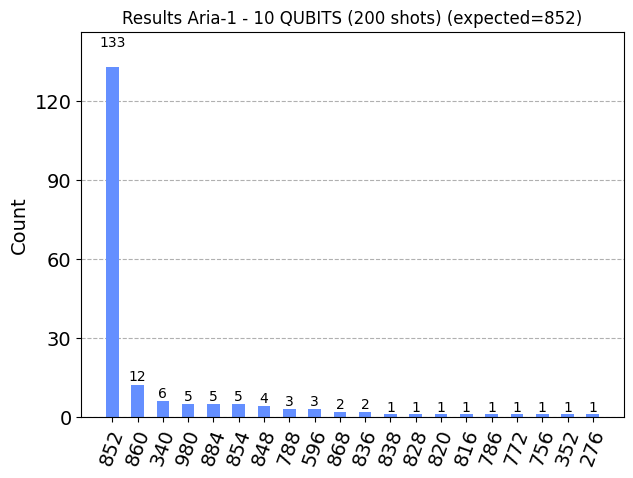

In [42]:
# Get the task results
measurement_counts = AwsQuantumTask(arn=aria1_circuit10_task_id).result().measurement_counts
# Transform labels into human-readable integers
# Keeps only the 20 higher counts
maxvals=20
measurement_counts_formated={}
for k, v in sorted(measurement_counts.items(), key=lambda o:o[1], reverse=True):
    maxvals-=1
    measurement_counts_formated.update({int(''.join(reversed(k)), 2):v})
    if maxvals<=0:
        break
# On vizualize les résultats avec Qiskit
QUBITS = 10
expected=sum([2**i for i in range(QUBITS-2, -1, -2)]) + 2**(QUBITS-1)-1
display(plot_histogram(measurement_counts_formated, title=f"Results Aria-1 - {QUBITS} QUBITS (200 shots) (expected={expected})", sort='value_desc'))

# Challenge Aria-1 on a 15 qubits addition

In [24]:
QUBITS = 15
# Init will always be 01010101...01
init_val = sum([2**i for i in range(QUBITS-2, -1, -2)])
# We always add 1111111...111 (QUBITS-1 times)
value_to_add = 2**(QUBITS-1)-1
circuit15 = get_quantum_adder(QUBITS, init_val, value_to_add)

print(f"Circuit depth: {circuit15.depth}")

# As I am not Cresus, 200 shots per experiment will have to do...
aria1_circuit15_task_id = aria1.run(circuit15, shots=200).id

Circuit depth: 195


In [43]:
print('Status of task:', AwsQuantumTask(arn=aria1_circuit15_task_id).state())

Status of task: COMPLETED


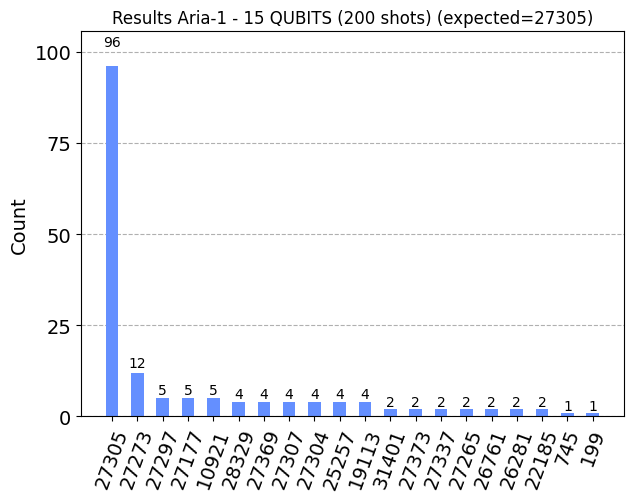

In [44]:
# Get the task results
measurement_counts = AwsQuantumTask(arn=aria1_circuit15_task_id).result().measurement_counts
# Transform labels into human-readable integers
# Keeps only the 20 higher counts
maxvals=20
measurement_counts_formated={}
for k, v in sorted(measurement_counts.items(), key=lambda o:o[1], reverse=True):
    maxvals-=1
    measurement_counts_formated.update({int(''.join(reversed(k)), 2):v})
    if maxvals<=0:
        break
# On vizualize les résultats avec Qiskit
QUBITS = 15
expected=sum([2**i for i in range(QUBITS-2, -1, -2)]) + 2**(QUBITS-1)-1
display(plot_histogram(measurement_counts_formated, title=f"Results Aria-1 - {QUBITS} QUBITS (200 shots) (expected={expected})", sort='value_desc'))

# Challenge Aria-1 on a 18 qubits addition

Beyond that, the service refuse the circuit because it is too big

In [28]:
QUBITS = 18
# Init will always be 01010101...01
init_val = sum([2**i for i in range(QUBITS-2, -1, -2)])
# We always add 1111111...111 (QUBITS-1 times)
value_to_add = 2**(QUBITS-1)-1
circuit18 = get_quantum_adder(QUBITS, init_val, value_to_add)

print(f"Circuit depth: {circuit18.depth}")

# As I am not Cresus, 200 shots per experiment will have to do...
aria1_circuit18_task_id = aria1.run(circuit18, shots=200).id

Circuit depth: 237


In [45]:
print('Status of task:', AwsQuantumTask(arn=aria1_circuit18_task_id).state())

Status of task: COMPLETED


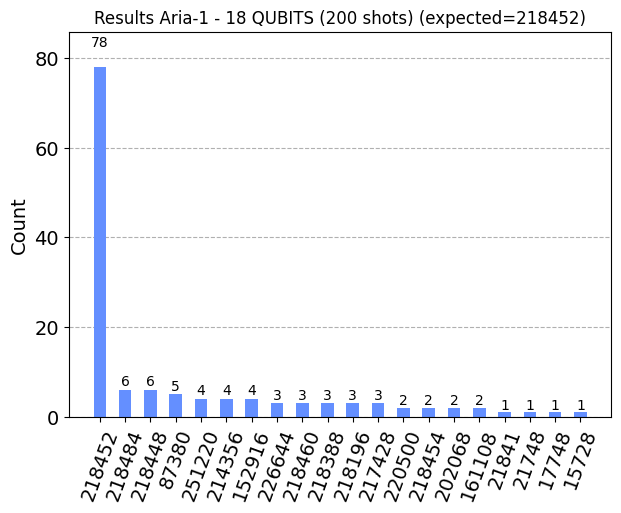

In [46]:
# Get the task results
measurement_counts = AwsQuantumTask(arn=aria1_circuit18_task_id).result().measurement_counts
# Transform labels into human-readable integers
# Keeps only the 20 higher counts
maxvals=20
measurement_counts_formated={}
for k, v in sorted(measurement_counts.items(), key=lambda o:o[1], reverse=True):
    maxvals-=1
    measurement_counts_formated.update({int(''.join(reversed(k)), 2):v})
    if maxvals<=0:
        break
# On vizualize les résultats avec Qiskit
QUBITS = 18
expected=sum([2**i for i in range(QUBITS-2, -1, -2)]) + 2**(QUBITS-1)-1
display(plot_histogram(measurement_counts_formated, title=f"Results Aria-1 - {QUBITS} QUBITS (200 shots) (expected={expected})", sort='value_desc'))